In [1]:
# Initial Imports:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# To run models:
from xgboost import XGBRegressor
from sklearn.model_selection import (GridSearchCV, TimeSeriesSplit, train_test_split)
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# For visualizations:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Define function to generate signals dataframe for algorithm:
def generate_signals(input_df, start_capital=100000, share_count=2000):
    # Set initial capital:
    initial_capital = float(start_capital)
    signals_df = input_df.copy()
    
    # Set the share size:
    share_size = share_count
    
    # Take a 500 share position where the Buy Signal is 1 (prior day's predictions greater than prior day's returns):
    signals_df['Position'] = share_size * signals_df['Buy Signal']
    
    # Make Entry / Exit Column:
    signals_df['Entry/Exit']=signals_df["Buy Signal"].diff()
    
    # Find the points in time where a 500 share position is bought or sold:
    signals_df['Entry/Exit Position'] = signals_df['Position'].diff()
    
    # Multiply share price by entry/exit positions and get the cumulative sum:
    signals_df['Portfolio Holdings'] = signals_df['Close'] * signals_df['Entry/Exit Position'].cumsum()
    
    # Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio: 
    signals_df['Portfolio Cash'] = initial_capital - (signals_df['Close'] * signals_df['Entry/Exit Position']).cumsum()
    
    # Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments):
    signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']
    
    # Calculate the portfolio daily returns:
    signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()
    
    # Calculate the cumulative returns:
    signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1
    signals_df = signals_df.dropna()
    
    return signals_df

In [3]:
def algo_evaluation(signals_df):
    # Prepare dataframe for metrics
    metrics = [
        'Annual Return',
        'Cumulative Returns',
        'Annual Volatility',
        'Sharpe Ratio',
        'Sortino Ratio']
    columns = ['Backtest']

    # Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
    portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
    # Calculate cumulative returns:
    portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'][-1]
    # Calculate annualized returns:
    portfolio_evaluation_df.loc['Annual Return'] = (signals_df['Portfolio Daily Returns'].mean() * 252)
    # Calculate annual volatility:
    portfolio_evaluation_df.loc['Annual Volatility'] = (signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))
    # Calculate Sharpe Ratio:
    portfolio_evaluation_df.loc['Sharpe Ratio'] = (signals_df['Portfolio Daily Returns'].mean() * 252) / (signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))
    #Calculate Sortino Ratio/Downside Return:
    sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
    sortino_ratio_df.loc[:,'Downside Returns'] = 0

    target = 0
    mask = sortino_ratio_df['Portfolio Daily Returns'] < target
    sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
    down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
    expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
    sortino_ratio = expected_return/down_stdev

    portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio


    return portfolio_evaluation_df

In [4]:
# Define function to evaluate the underlying asset:
def underlying_evaluation(signals_df):
    underlying=pd.DataFrame()
    underlying["Close"]=signals_df["Close"]
    underlying["Portfolio Daily Returns"]=underlying["Close"].pct_change()
    underlying["Portfolio Daily Returns"].fillna(0,inplace=True)
    underlying['Portfolio Cumulative Returns']=(1 + underlying['Portfolio Daily Returns']).cumprod() - 1

    underlying_evaluation=algo_evaluation(underlying)

    return underlying_evaluation    

In [5]:
# Define function to return algo evaluation relative to underlying asset combines the two evaluations into a single dataframe
def algo_vs_underlying(signals_df):
    metrics = [
        'Annual Return',
        'Cumulative Returns',
        'Annual Volatility',
        'Sharpe Ratio',
        'Sortino Ratio']

    columns = ['Algo','Underlying']
    algo=algo_evaluation(signals_df)
    underlying=underlying_evaluation(signals_df)

    comparison_df=pd.DataFrame(index=metrics,columns=columns)
    comparison_df['Algo']=algo['Backtest']
    comparison_df['Underlying']=underlying['Backtest']

    return comparison_df

In [6]:
# Define function which accepts daily signals dataframe and returns evaluations of individual trades:
def trade_evaluation(signals_df):
    #initialize dataframe
    trade_evaluation_df = pd.DataFrame(
        columns=[
            'Entry Date', 
            'Exit Date', 
            'Shares', 
            'Entry Share Price', 
            'Exit Share Price', 
            'Entry Portfolio Holding', 
            'Exit Portfolio Holding', 
            'Profit/Loss'])
  
  
    entry_date = ''
    exit_date = ''
    entry_portfolio_holding = 0
    exit_portfolio_holding = 0
    share_size = 0
    entry_share_price = 0
    exit_share_price = 0

  # Loop through signal DataFrame
  # If `Entry/Exit` is 1, set entry trade metrics
  # Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
  # Then append the record to the trade evaluation DataFrame
    for index, row in signals_df.iterrows():
        if row['Entry/Exit'] == 1:
            entry_date = index
            entry_portfolio_holding = row['Portfolio Total']
            share_size = row['Entry/Exit Position']
            entry_share_price = row['Close']
            
        elif row['Entry/Exit'] == -1:
            exit_date = index
            exit_portfolio_holding = abs(row['Portfolio Total'])
            exit_share_price = row['Close']
            profit_loss = exit_portfolio_holding - entry_portfolio_holding
            trade_evaluation_df = trade_evaluation_df.append(
                {'Entry Date': entry_date,
                  'Exit Date': exit_date,
                  'Shares': share_size,
                  'Entry Share Price': entry_share_price,
                  'Exit Share Price': exit_share_price,
                  'Entry Portfolio Holding': entry_portfolio_holding,
                  'Exit Portfolio Holding': exit_portfolio_holding,
                  'Profit/Loss': profit_loss
                },
                ignore_index=True)
            # Print the DataFrame
    return trade_evaluation_df

In [7]:
# Define function that plots Algo Cumulative Returns vs. Underlying Cumulative Returns:
def underlying_returns(signals_df):
    underlying=pd.DataFrame()
    underlying["Close"]=signals_df["Close"]
    underlying["Underlying Daily Returns"]=underlying["Close"].pct_change()
    underlying["Underlying Daily Returns"].fillna(0,inplace=True)
    underlying['Underlying Cumulative Returns']=(1 + underlying['Underlying Daily Returns']).cumprod() - 1
    underlying['Algo Cumulative Returns']=signals_df["Portfolio Cumulative Returns"]

    graph_df=underlying[["Underlying Cumulative Returns", "Algo Cumulative Returns"]]

    return graph_df

In [8]:
all_data  = pd.read_csv('all_data.csv', index_col='Date', parse_dates=True)

In [9]:
all_data

,Mkt-RF,SMB,HML,RMW,CMA,RF,cdd_18-France,cdd_18-Germany,cdd_18-India,cdd_18-Indonesia,...,ret_ETN,ret_GOOGL,ret_HD,ret_HIG,ret_MS,ret_MSFT,ret_PLD,ret_TT,ret_UNH,ret_V
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-30,-0.0307,-0.0280,0.0056,0.0180,-0.0060,0.0000,7.58800,1.4840,313.40,233.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-31,0.0775,-0.0205,-0.0046,0.0086,0.0055,0.0000,0.59810,0.0000,280.10,263.1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-11-30,0.0056,0.0329,-0.0042,-0.0271,-0.0103,0.0000,0.01212,0.0000,169.60,256.0,...,0.144820,0.194997,0.159235,0.001563,0.093980,0.236248,0.098971,0.155604,-0.028446,0.136261
2015-12-31,-0.0217,-0.0297,-0.0261,0.0045,0.0003,0.0001,0.00000,0.0000,88.83,250.7,...,-0.105227,0.019873,-0.007803,-0.047765,-0.072595,0.020791,0.013633,-0.052648,0.048249,-0.018478
2016-01-31,-0.0577,-0.0348,0.0209,0.0280,0.0307,0.0001,0.00000,0.0000,72.22,260.8,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-0.0377,0.0149,0.0030,-0.0478,0.0130,0.0019,137.80000,90.4000,314.80,233.5,...,0.090445,-0.006819,0.058453,-0.011266,0.131055,0.020227,0.058308,0.186340,0.011098,0.011031
2022-09-30,-0.0935,-0.0097,0.0006,-0.0151,-0.0084,0.0019,35.78000,8.6410,292.60,231.5,...,-0.024005,-0.116152,-0.043270,-0.036853,-0.072870,-0.109267,-0.178815,-0.055997,-0.024465,-0.105984
2022-10-31,0.0783,0.0186,0.0805,0.0307,0.0652,0.0023,7.65100,0.1096,240.10,232.9,...,0.125300,-0.011918,0.073168,0.169035,0.050081,-0.003306,0.090059,0.102341,0.099220,0.166113


In [10]:
all_data = all_data.iloc[1:,]
all_data = all_data.ffill()

In [ ]:
stock_list = ['ret_AAPL', 'ret_APTV', 'ret_BAC', 'ret_BALL', 'ret_BEP', 'ret_BKNG', 
              'ret_BMRN', 'ret_COST', 'ret_CVS', 'ret_DE', 'ret_ETN', 'ret_GOOGL', 'ret_HD', 
              'ret_HIG', 'ret_MS', 'ret_MSFT', 'ret_PLD', 'ret_TT', 'ret_UNH', 'ret_V']

# AAPL

In [ ]:
# Define X and y variables:
X = all_data.drop(stock_list, axis=1)
X = X.drop('ret_Fund' ,axis=1)
y = all_data.loc[:, 'ret_AAPL']

In [ ]:
# Split into Training/Testing Data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
close_test=all_data["AAPL"][split:]
close_test

In [ ]:
%%time
params={'gamma':[0, 0.01, 0.05, 0.1, 0.5, 1, 2, 3], 
        'colsample_bylevel':[0.9], 
        'colsample_bytree':[0.8], 
        'colsample_bynode':[0.5], 
        'max_depth':np.arange(4, 10 ,2), 
        'n_estimators':[100,200],
        'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
        'min_child_weight':[1, 2, 3, 4, 5], 
        'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5]}

xgb_reg = GridSearchCV(XGBRegressor(booster = 'gbtree'), params, cv=5, n_jobs=-1)

grid_result = xgb_reg.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

In [ ]:
predictions = xgb_reg.predict(X_test)
print('mean_squared_error =\t\t', mean_squared_error(y_test, predictions))
print('mean_absolute_error =\t\t', mean_absolute_error(y_test, predictions))

In [ ]:
# Convert y_test to a dataframe:
y_test = y_test.to_frame()

In [ ]:
signals_df = y_test.copy()

# Add "predictions" to dataframe:
y_test['Predictions'] = predictions
y_test["Close"]=close_test

# Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['ret_AAPL'], 1.0,0.0)

# Drop nulls:
y_test=y_test.dropna()

y_test.head()

In [ ]:
# Generate and view signals dataframe using generate signals function
signals_df=generate_signals(y_test)
signals_df.head(10)

In [ ]:
# Generate Metrics for Algorithm:
algo_evaluation(signals_df)

In [ ]:
# Generate Metrics for Function vs. Buy-and-Hold Strategy:
algo_vs_underlying(signals_df)

In [ ]:
# Generate Evaluation table:
trade_evaluation_df=trade_evaluation(signals_df)
trade_evaluation_df

In [ ]:
# Generate Cumulative Return plot using above defined function:
underlying_returns(signals_df).plot(figsize=(20,10))

# BAC

In [11]:
stock_list = ['AAPL', 'APTV', 'BAC', 'BALL', 'BEP', 'BKNG', 'BMRN', 'COST', 'CVS', 'DE', 'ETN', 'GOOGL', 'HD', 'HIG', 'MS', 'MSFT', 'PLD', 'TT', 'UNH', 'V']

AAPL
mean_squared_error =		 0.0017717400052724018
mean_absolute_error =		 0.03191025532304044
APTV
mean_squared_error =		 0.0008390968024611524
mean_absolute_error =		 0.02051985336103331
BAC
mean_squared_error =		 0.0010556125969709046
mean_absolute_error =		 0.021943924329526677
BALL
mean_squared_error =		 0.005932720743377386
mean_absolute_error =		 0.046898521788030695
BEP
mean_squared_error =		 0.003626480044022463
mean_absolute_error =		 0.042703450404165316
BKNG
mean_squared_error =		 0.0036031880994172294
mean_absolute_error =		 0.04219197328203172
BMRN
mean_squared_error =		 0.001331528521227635
mean_absolute_error =		 0.023878782590475583
COST
mean_squared_error =		 0.005218273306856308
mean_absolute_error =		 0.04690496437632105
CVS
mean_squared_error =		 0.0008361933190407897
mean_absolute_error =		 0.01730863092305095
DE
mean_squared_error =		 0.00399258228393665
mean_absolute_error =		 0.04827607408319927
ETN
mean_squared_error =		 0.0017999665747541714
mean_absolute_erro

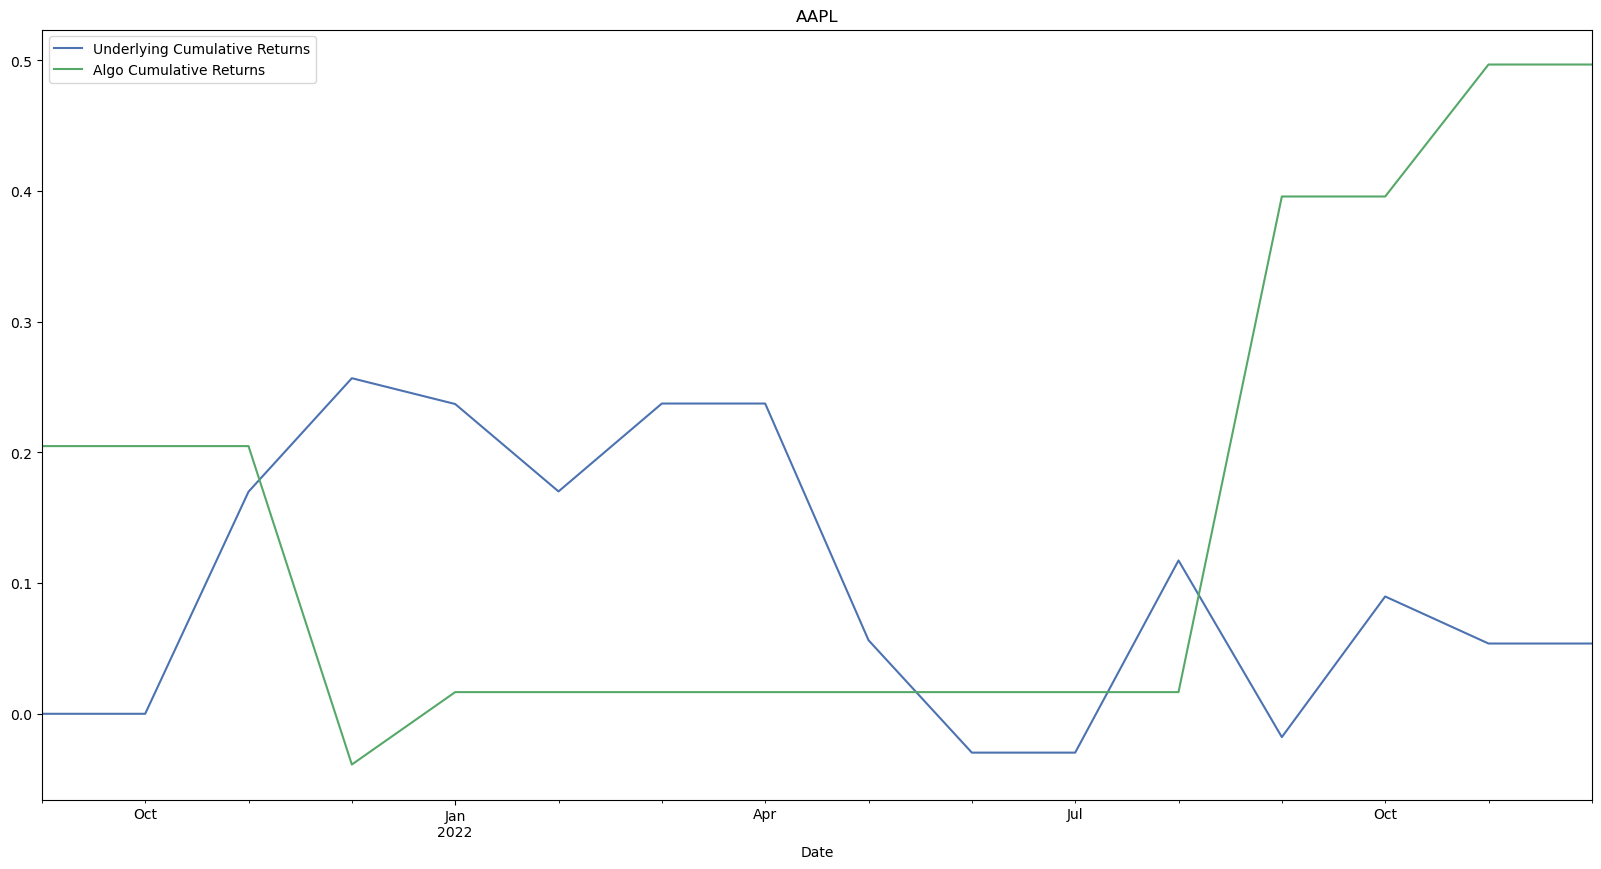

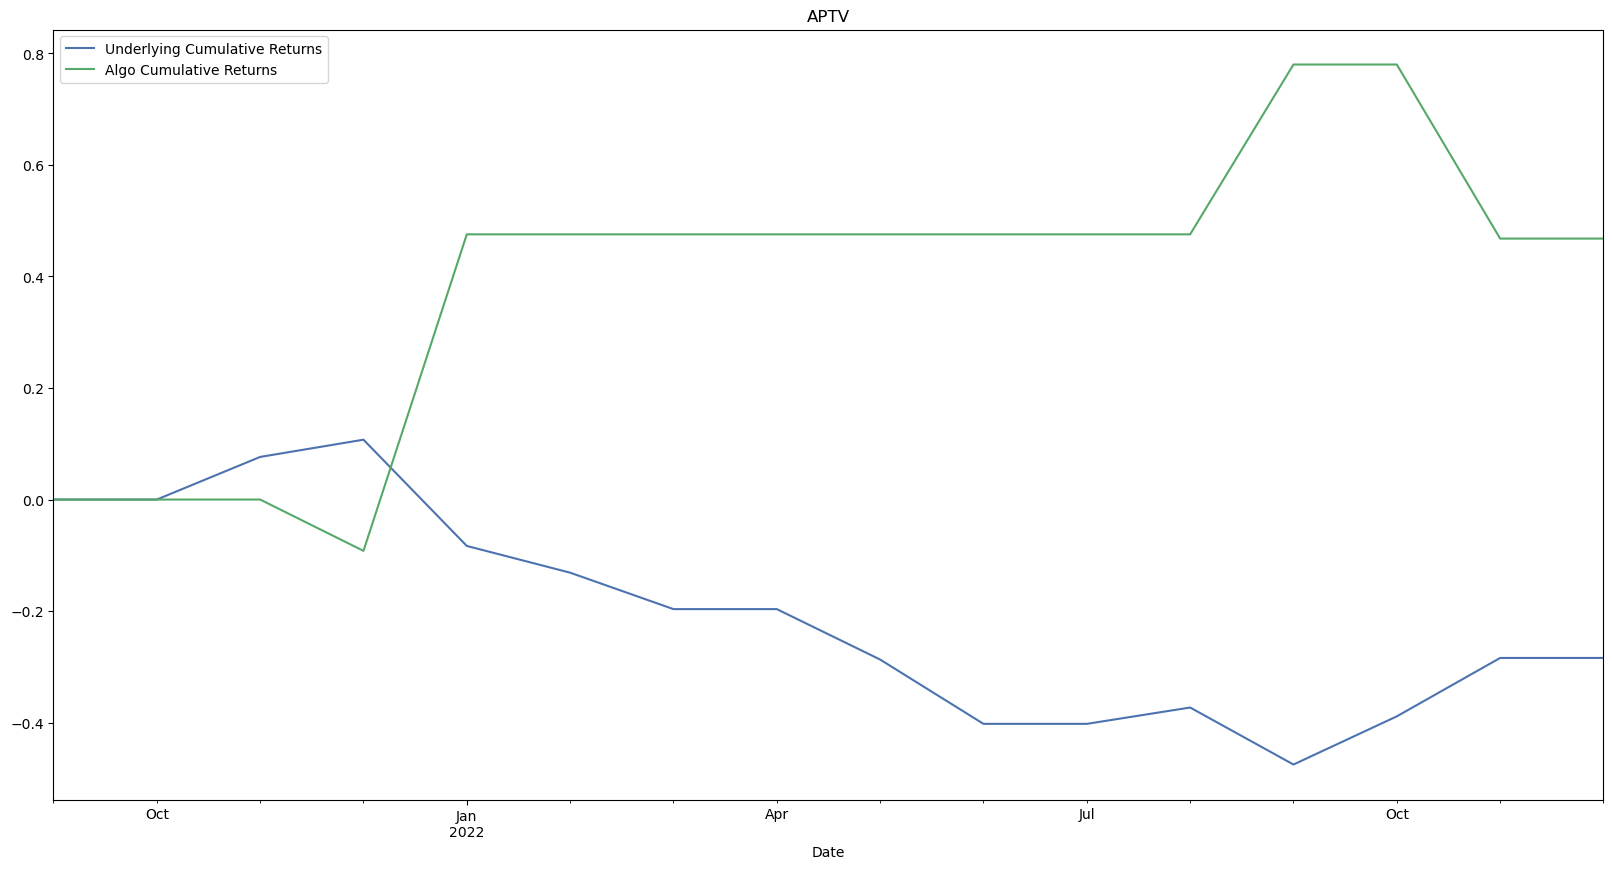

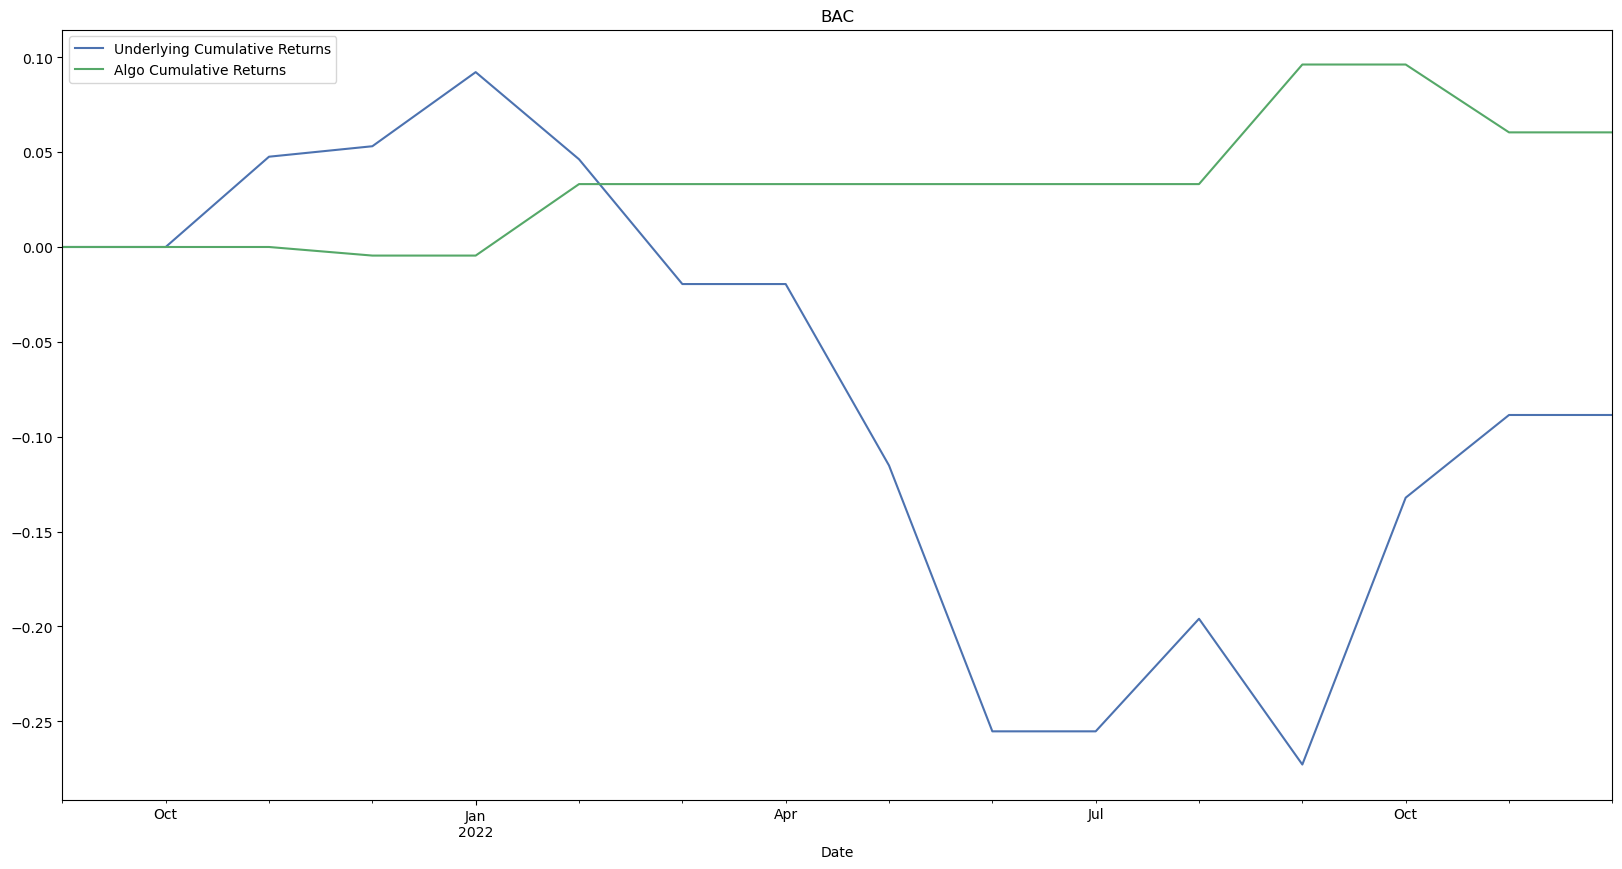

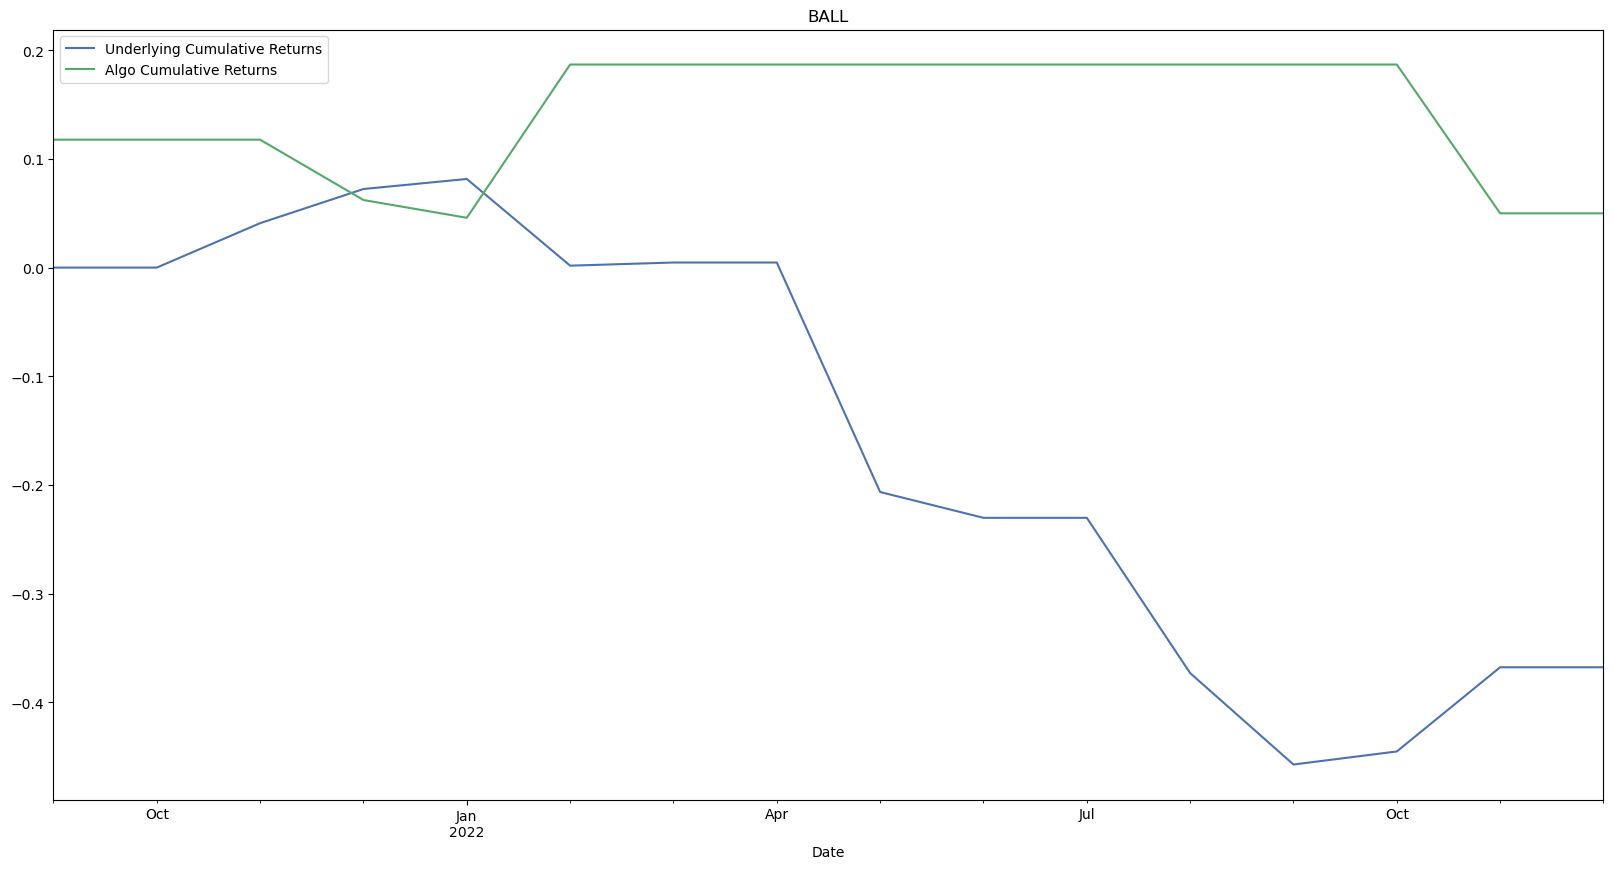

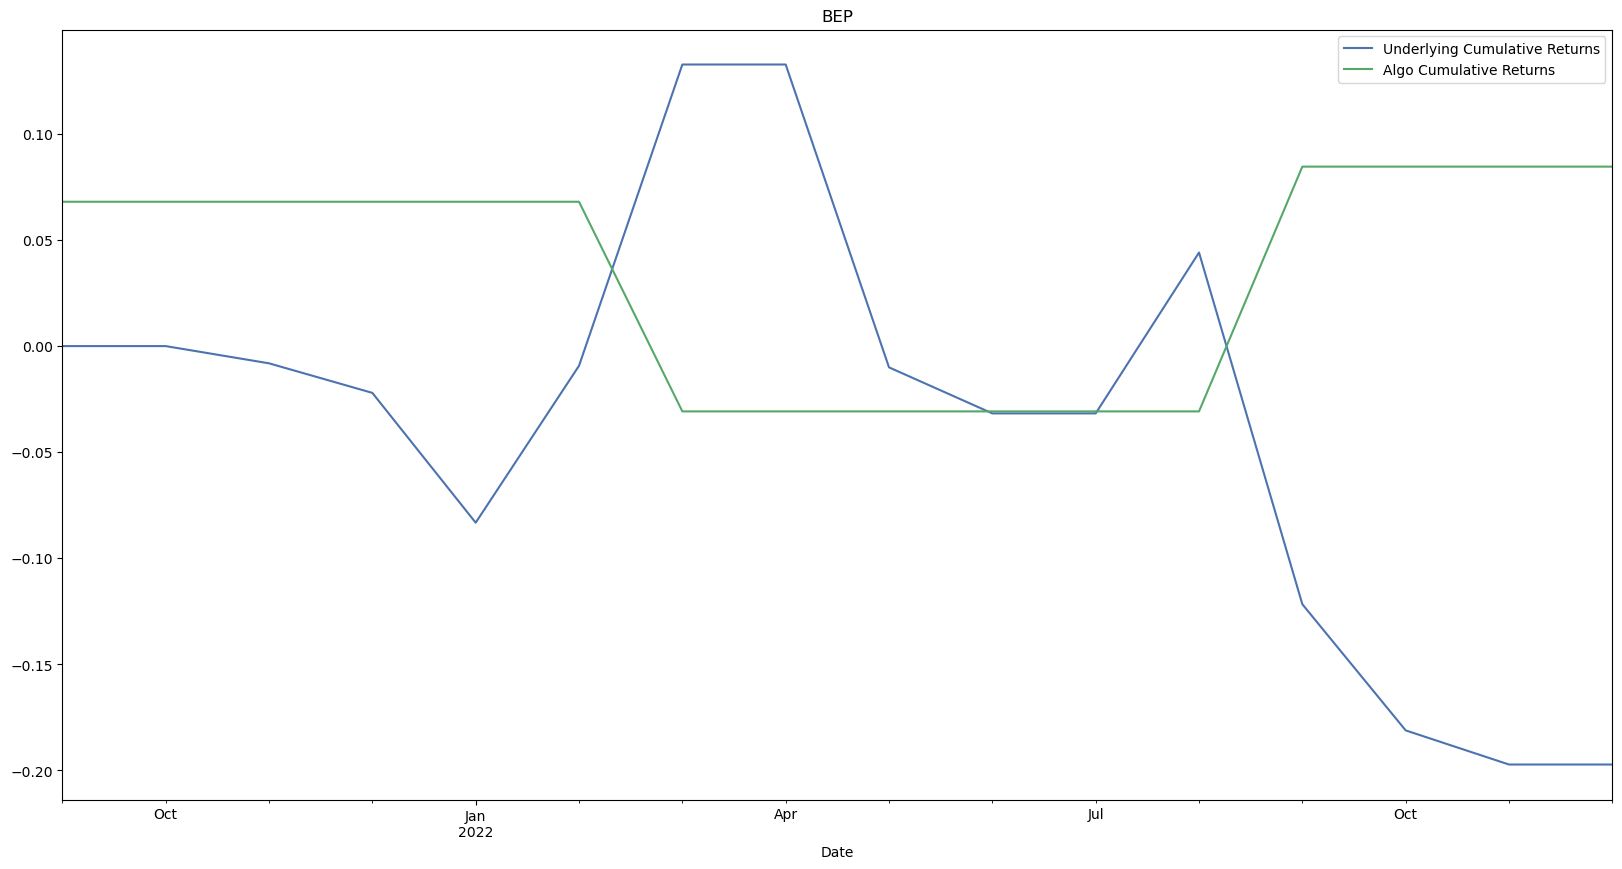

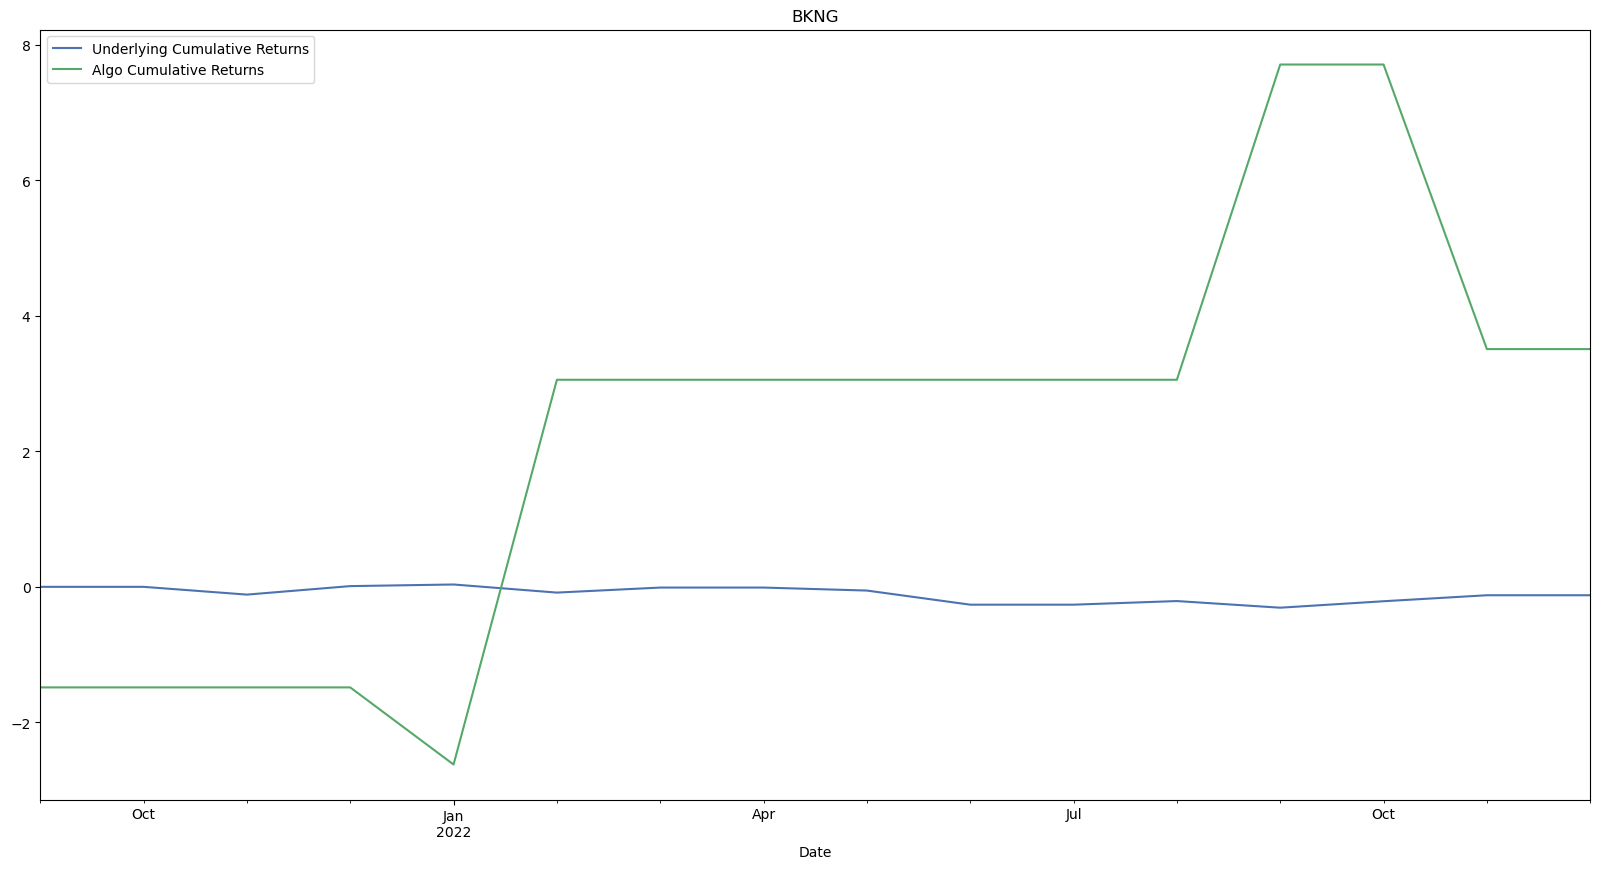

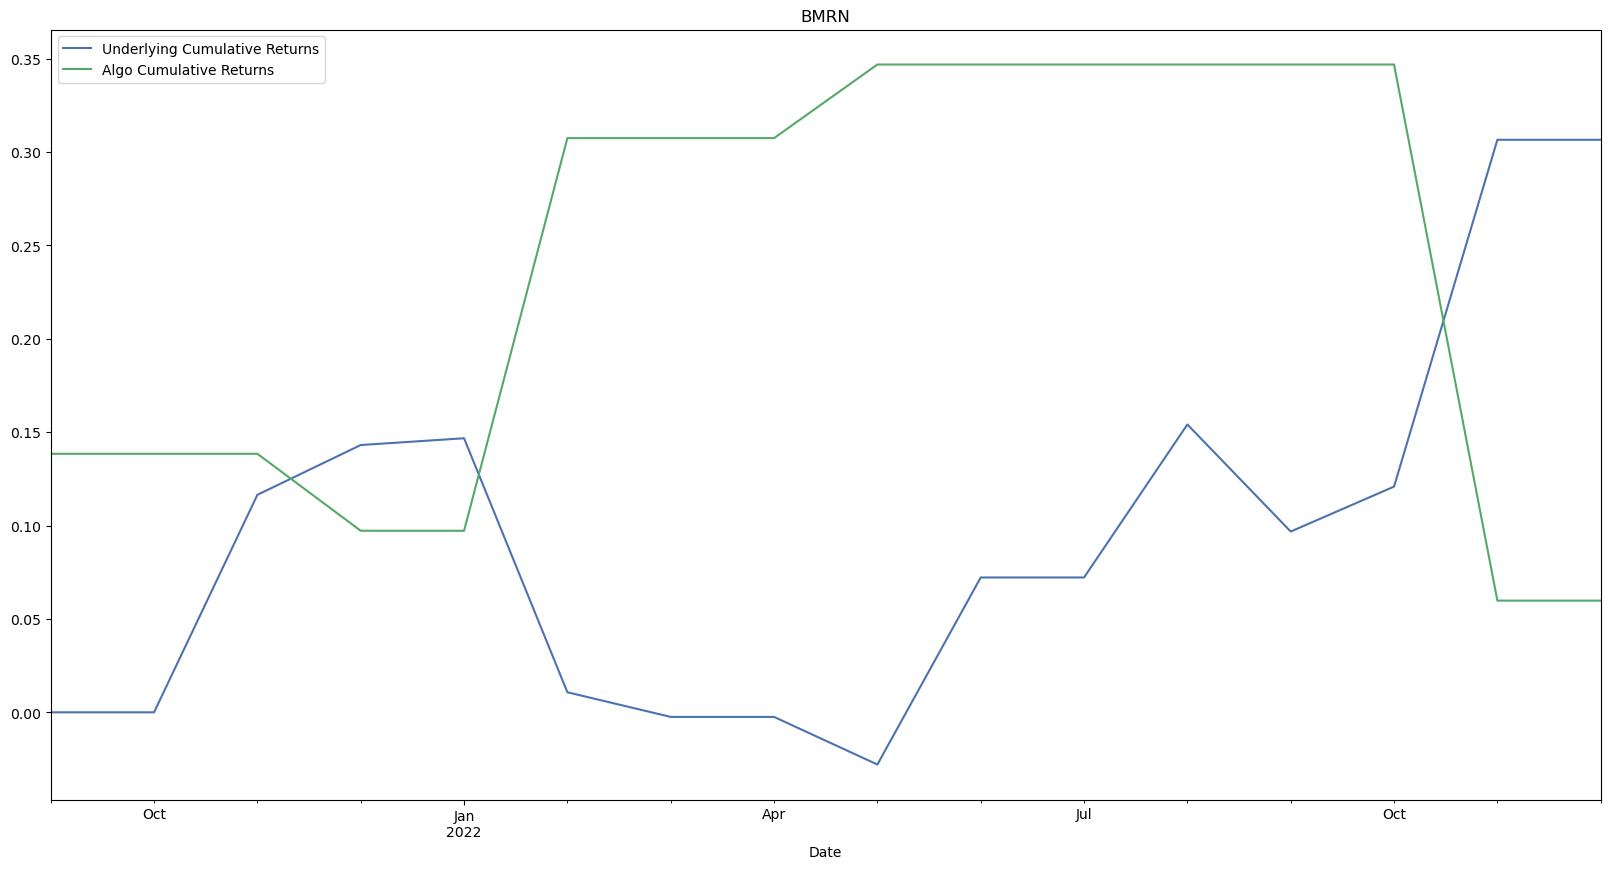

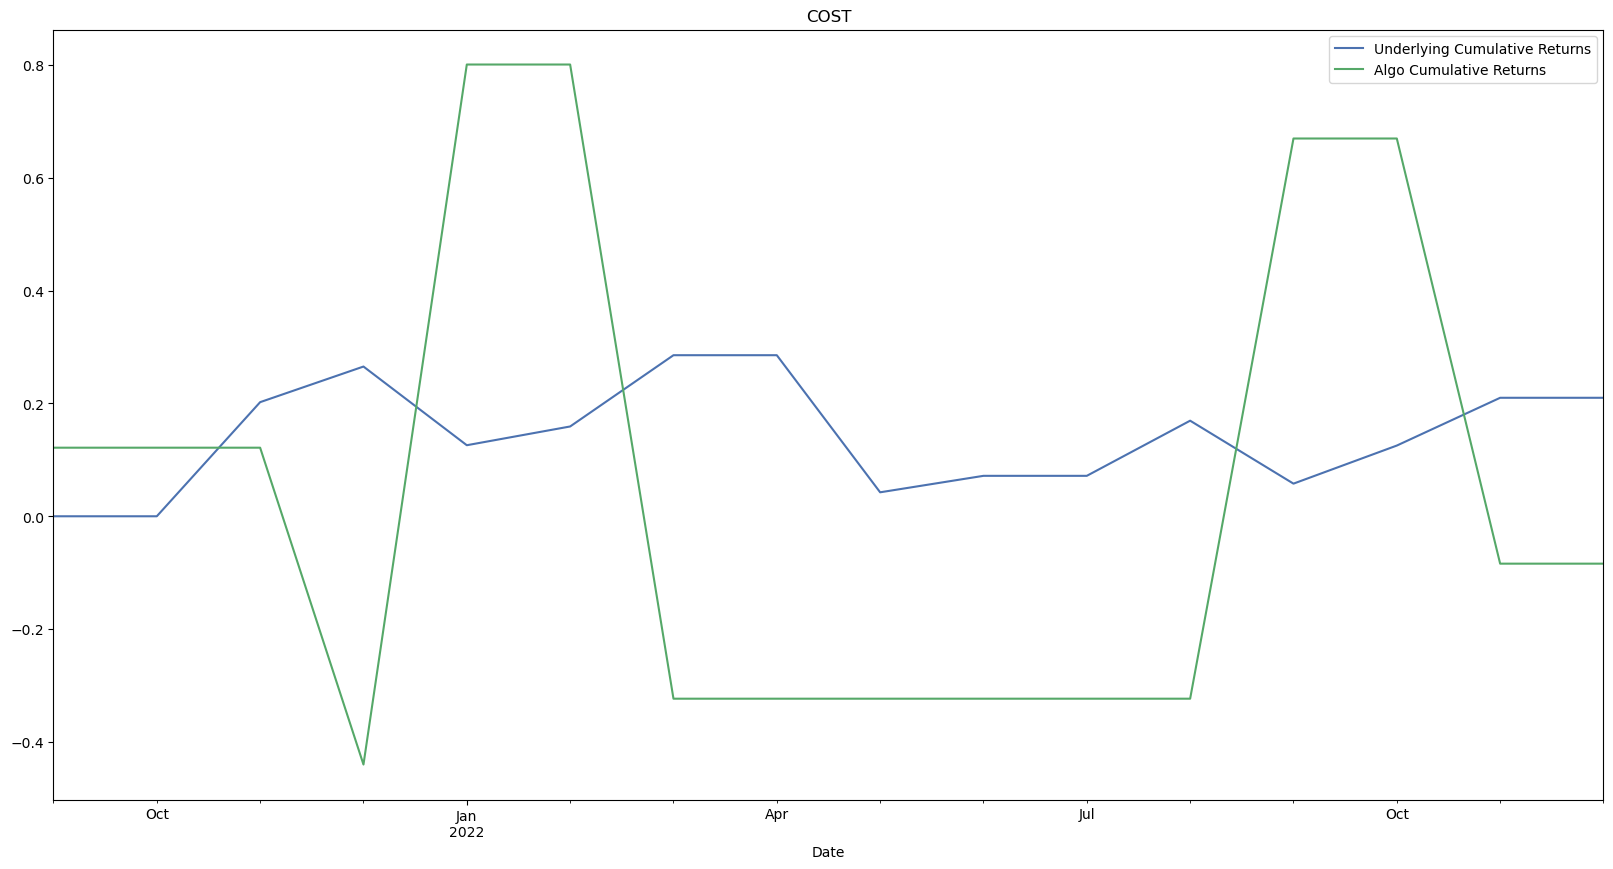

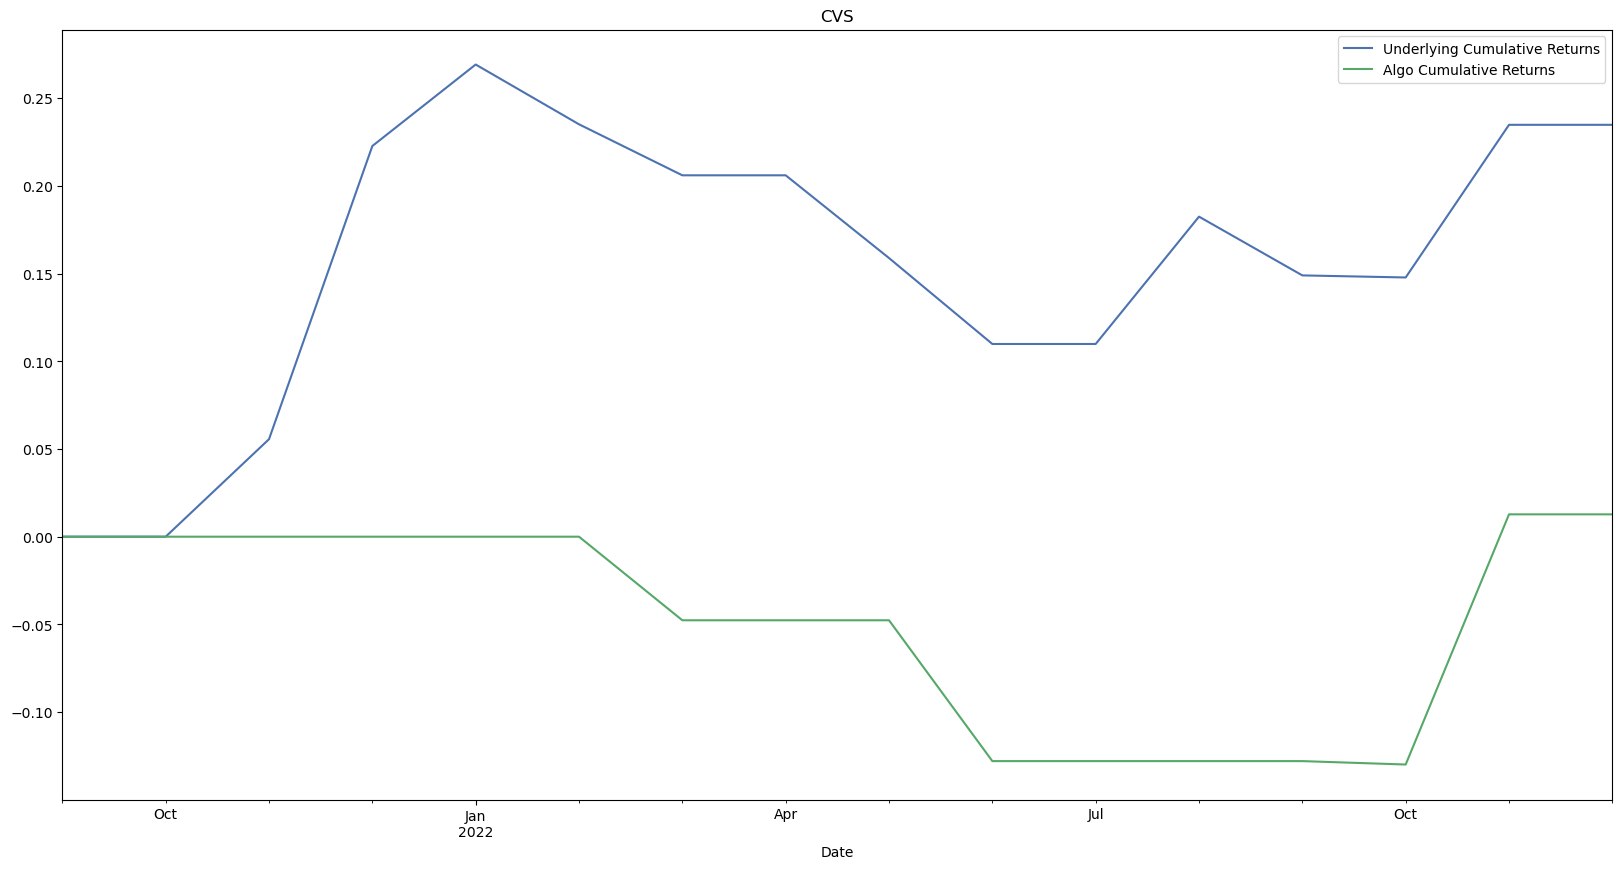

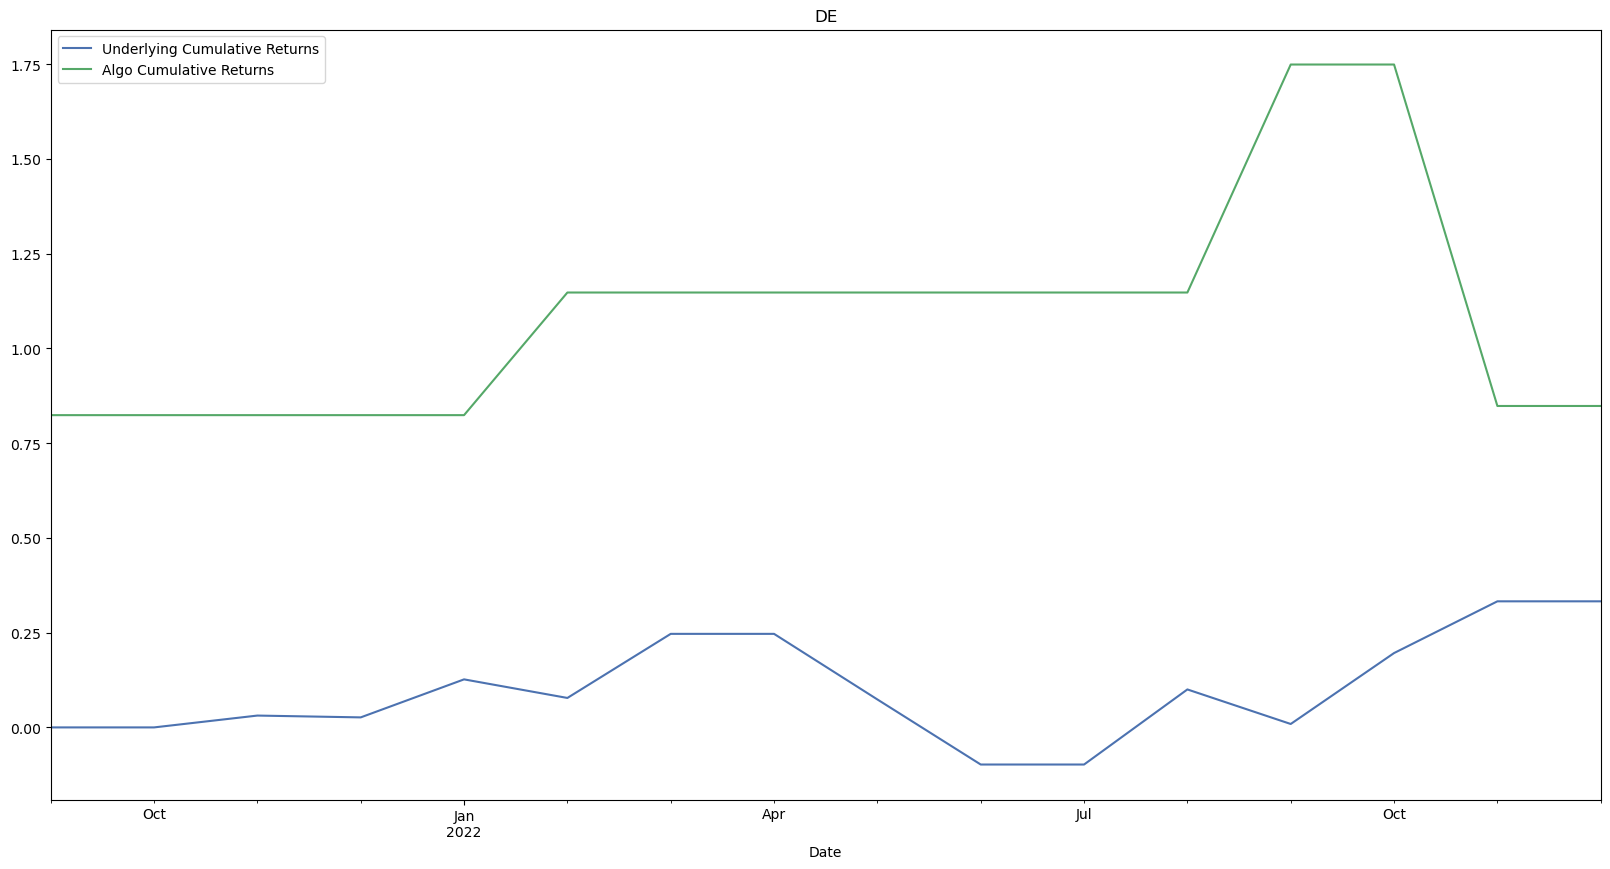

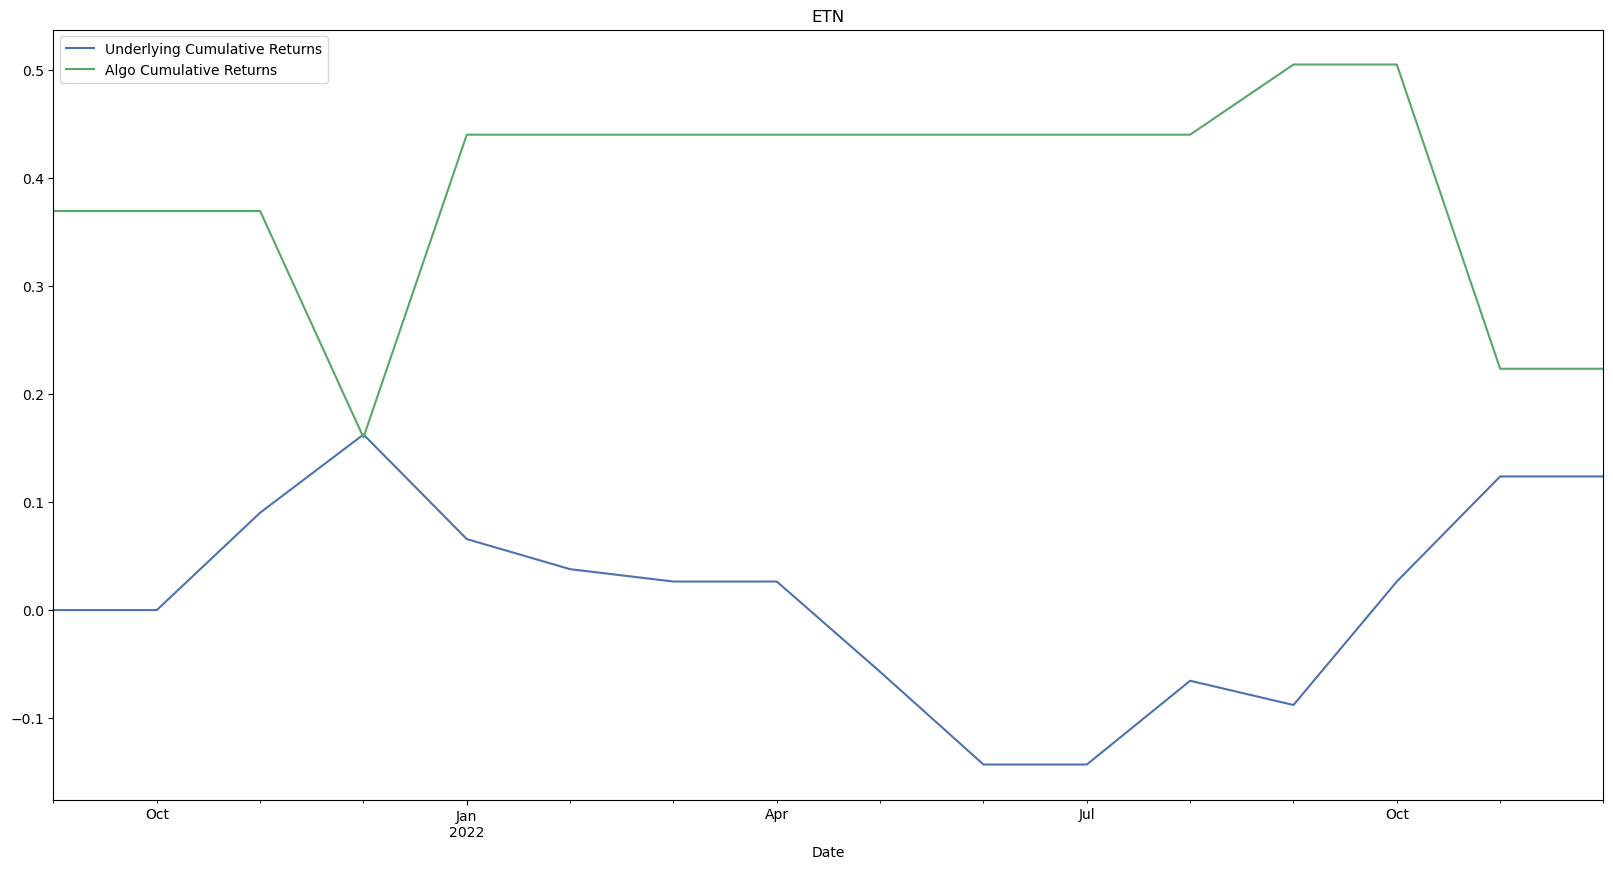

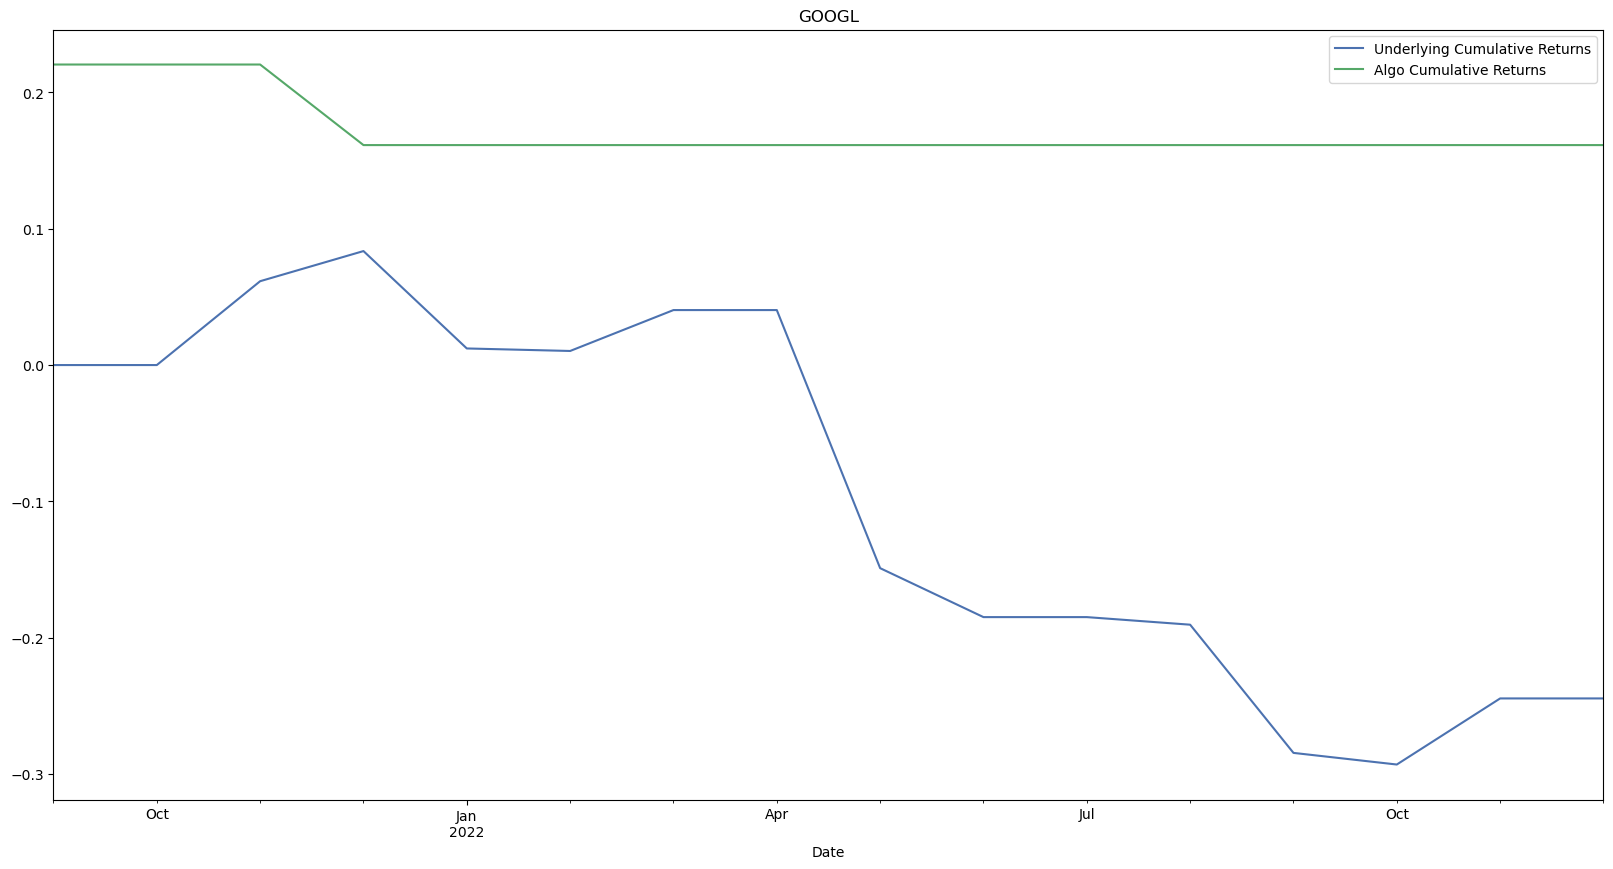

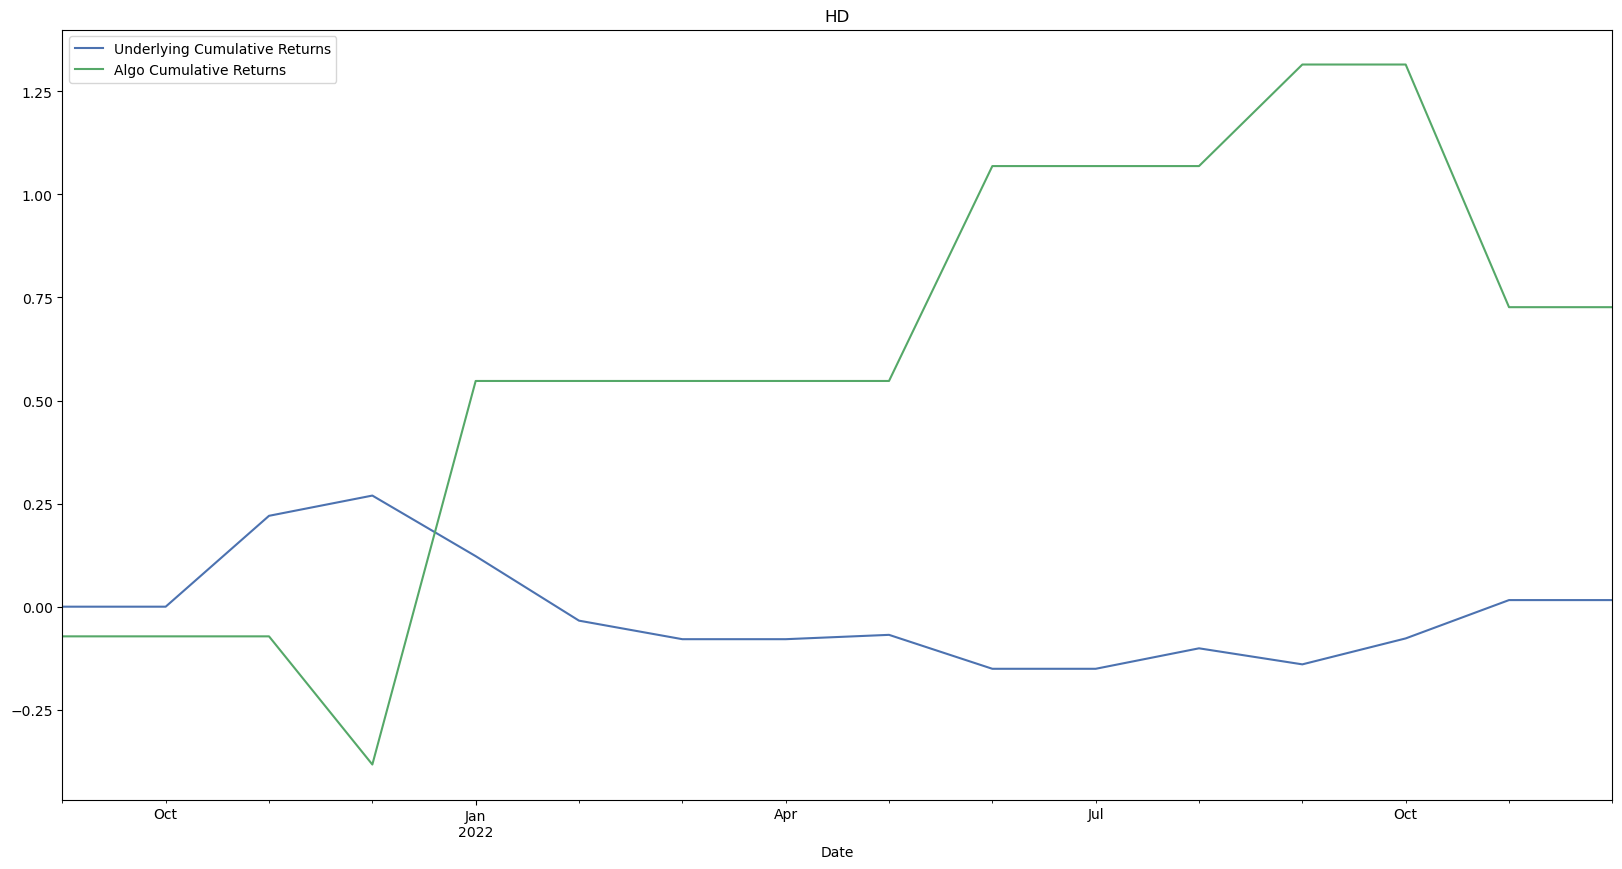

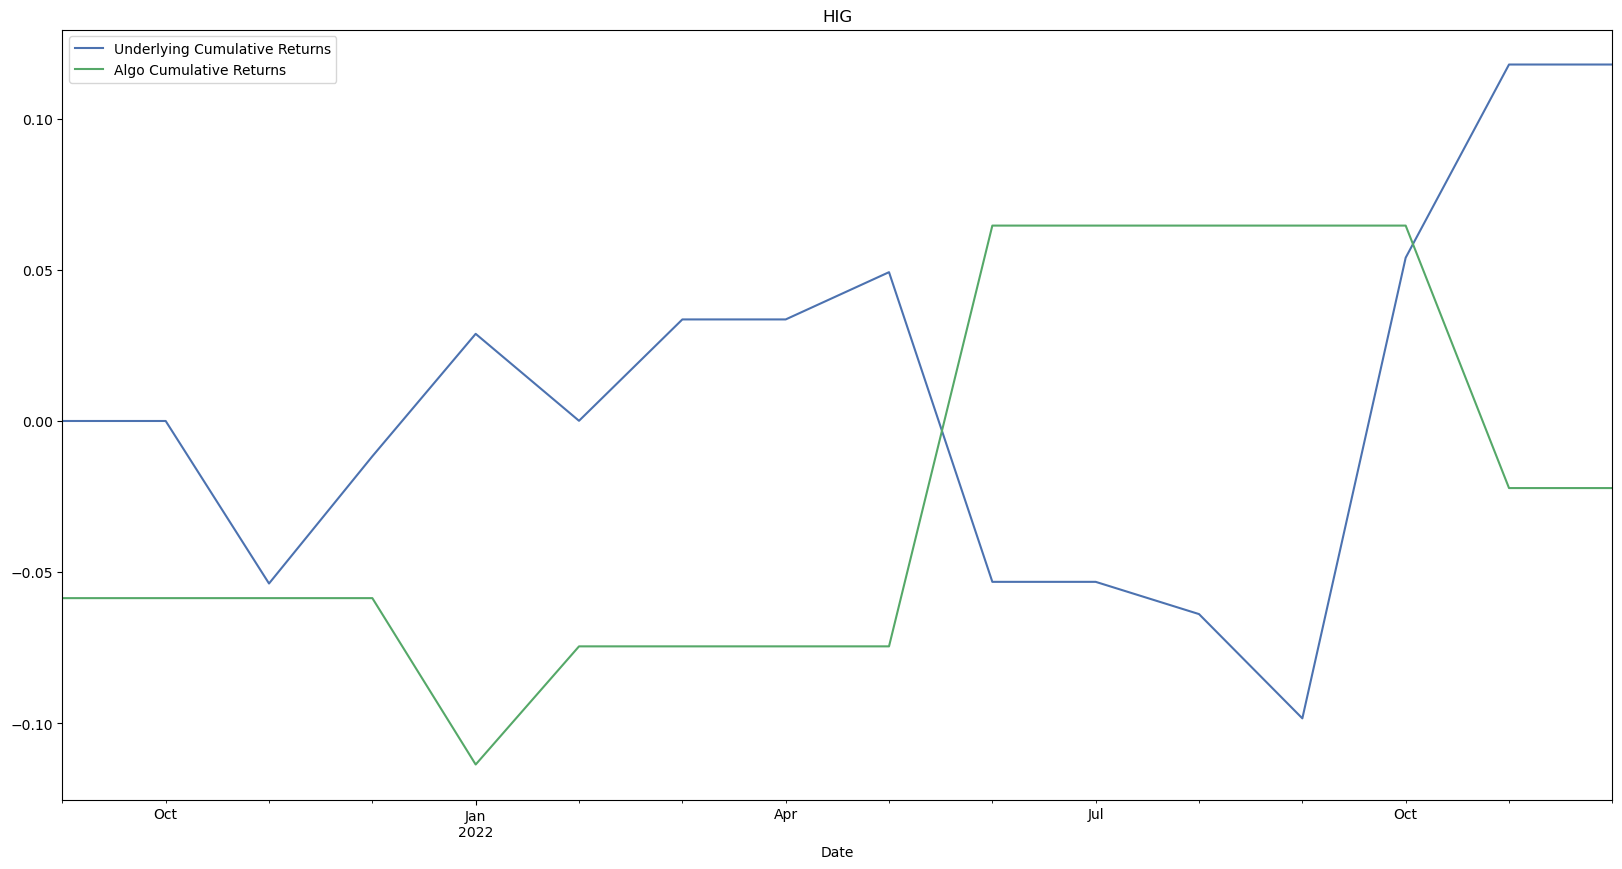

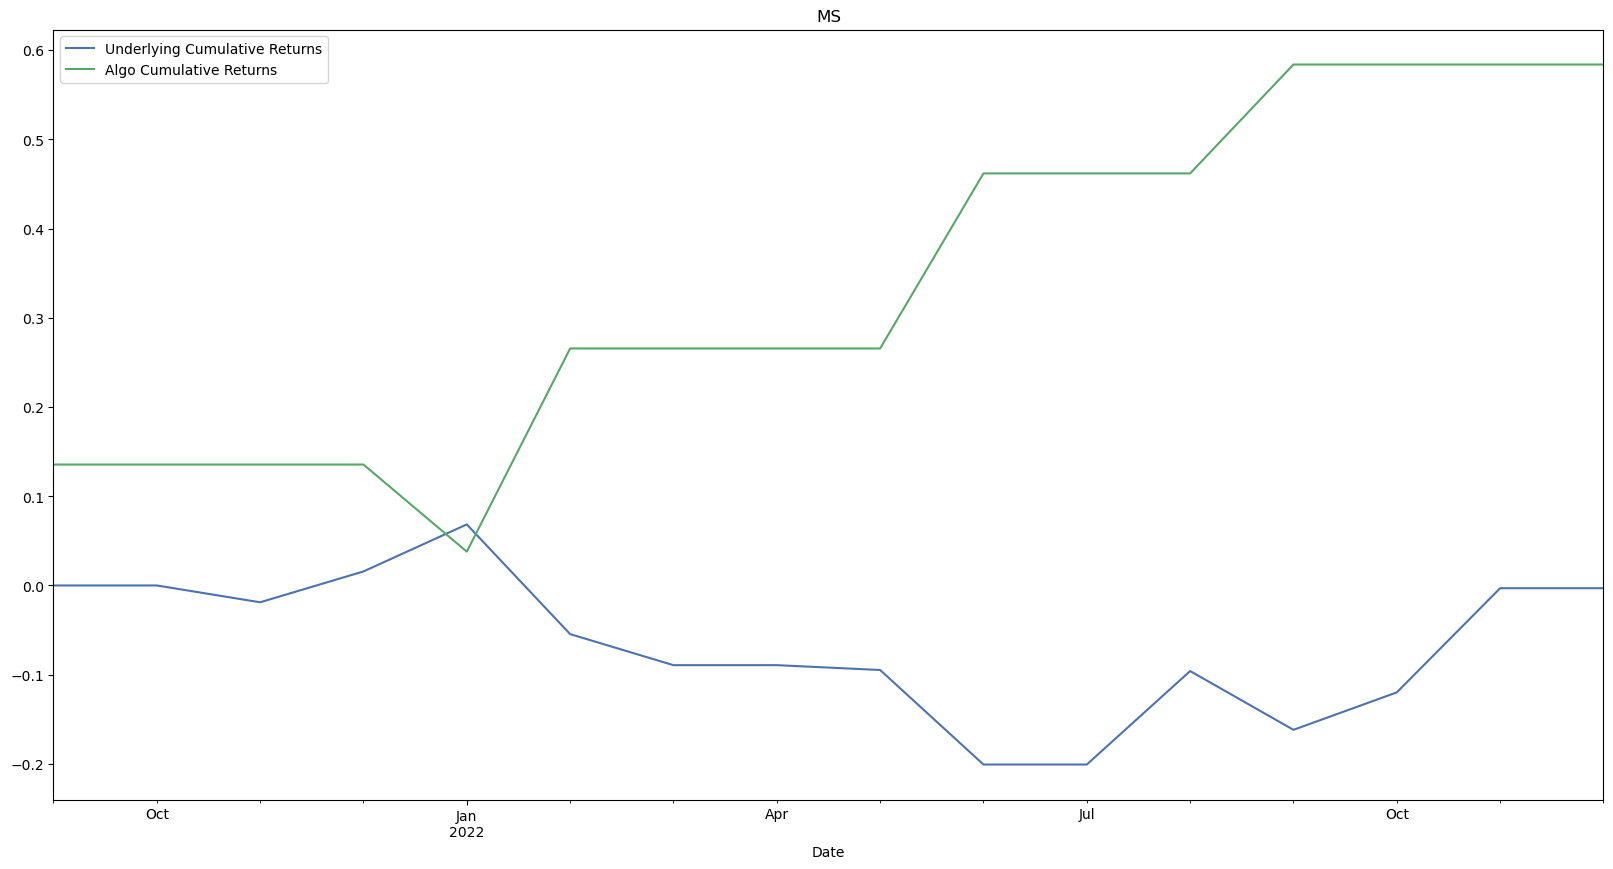

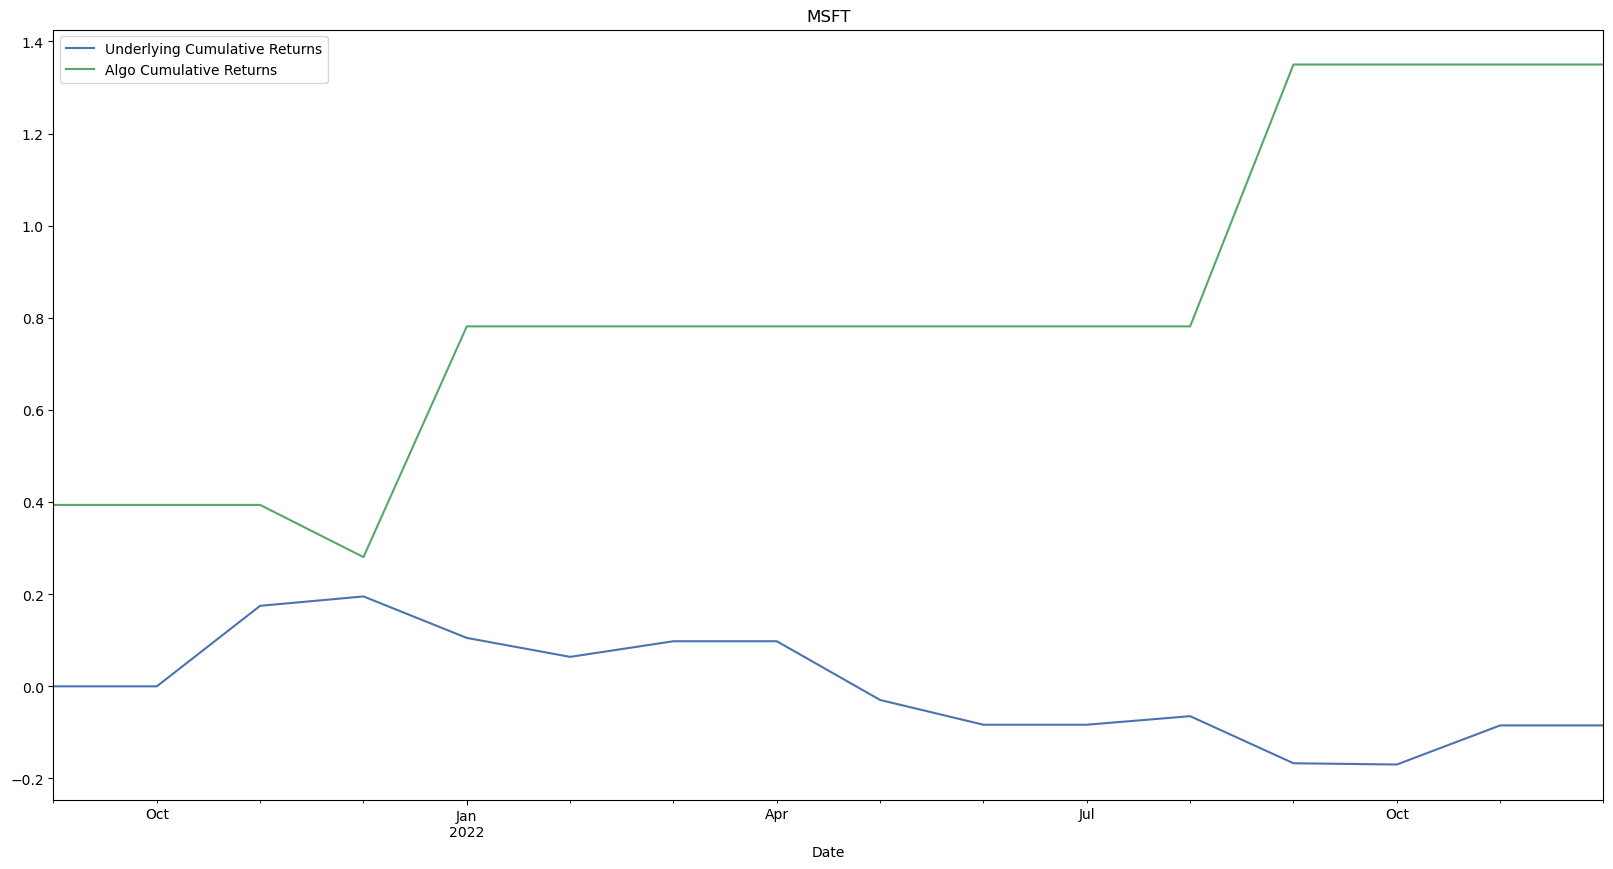

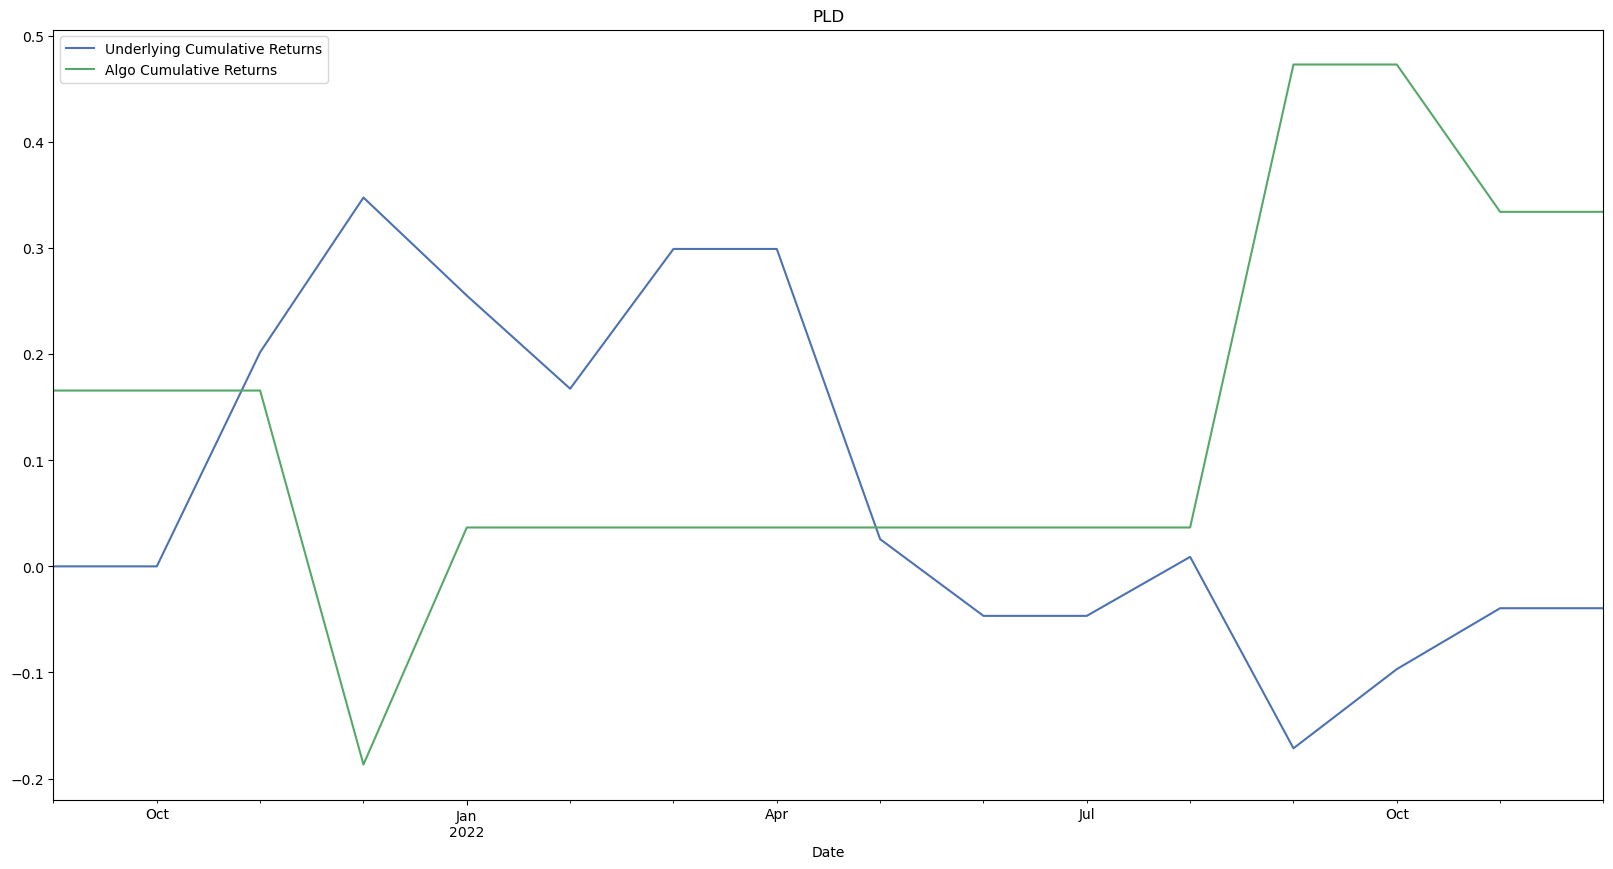

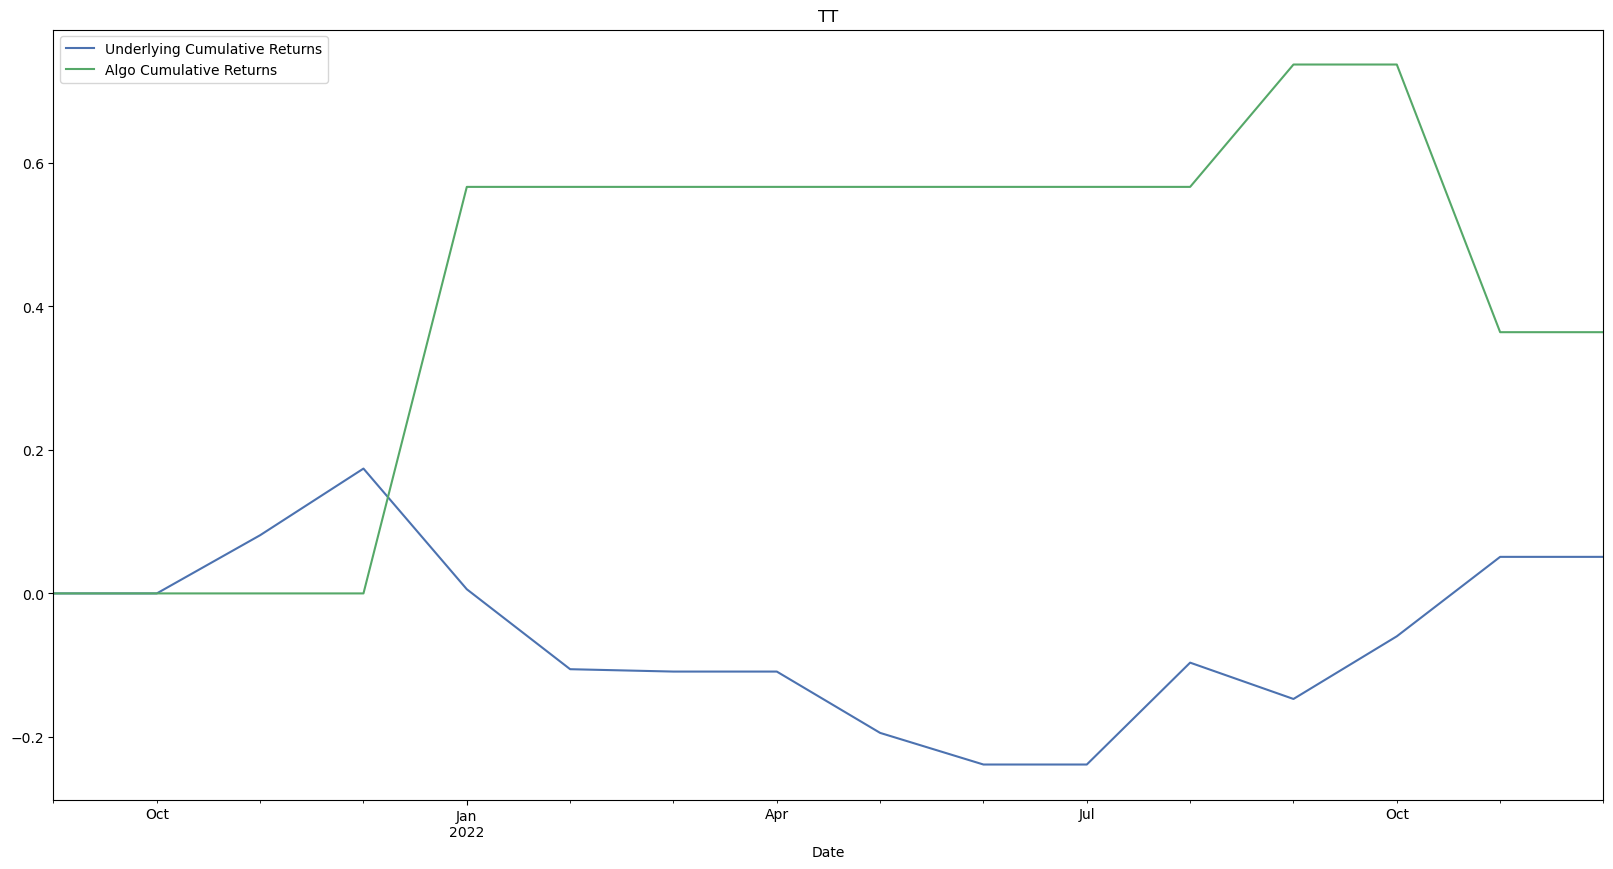

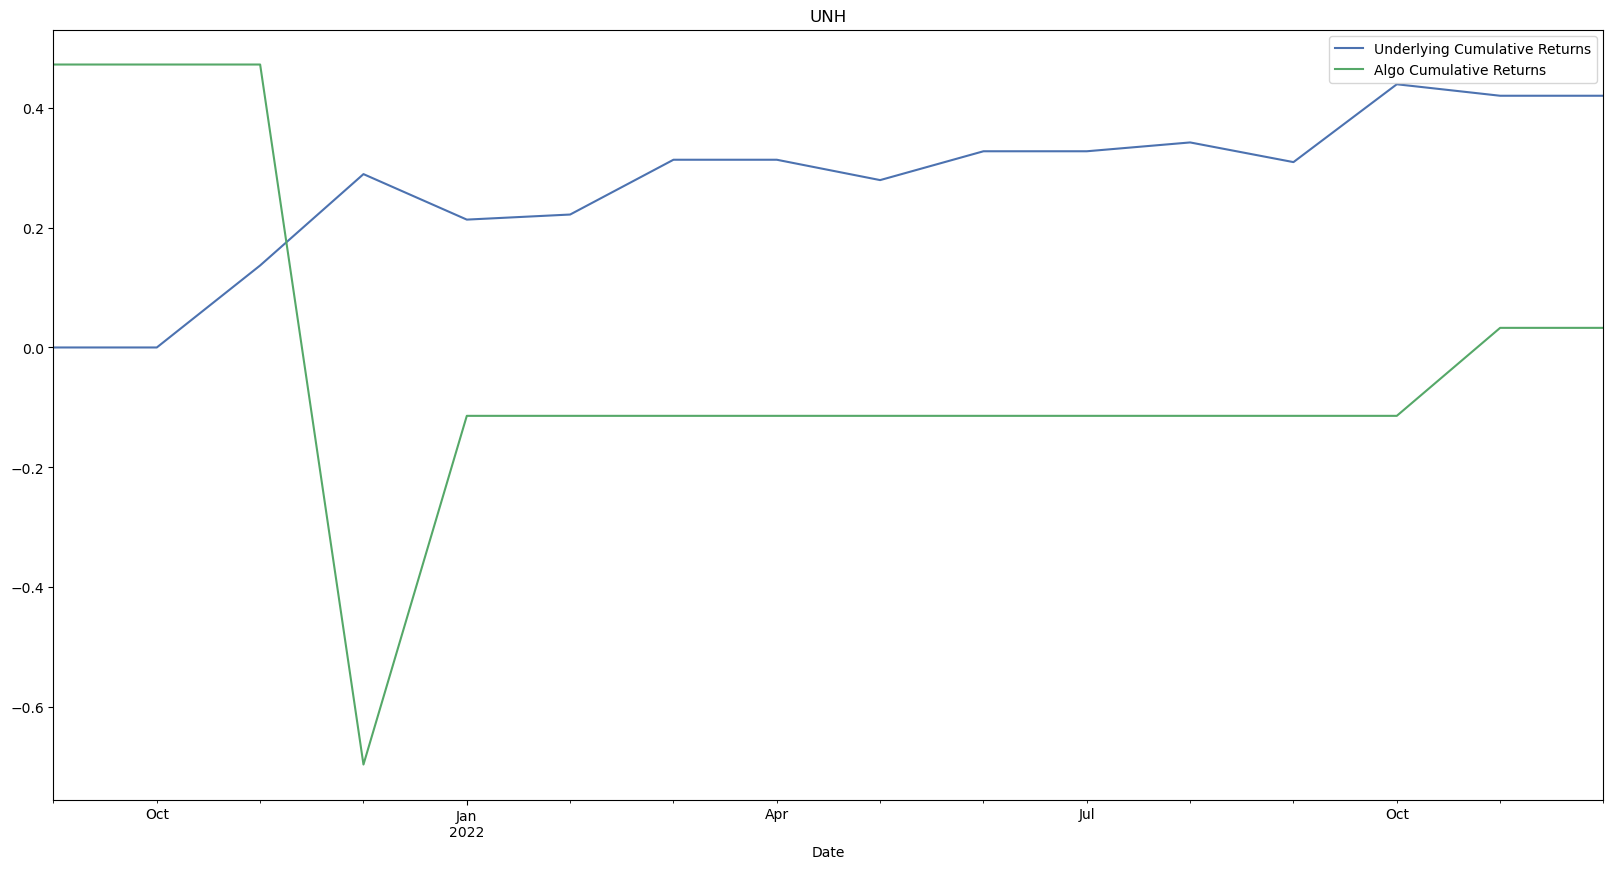

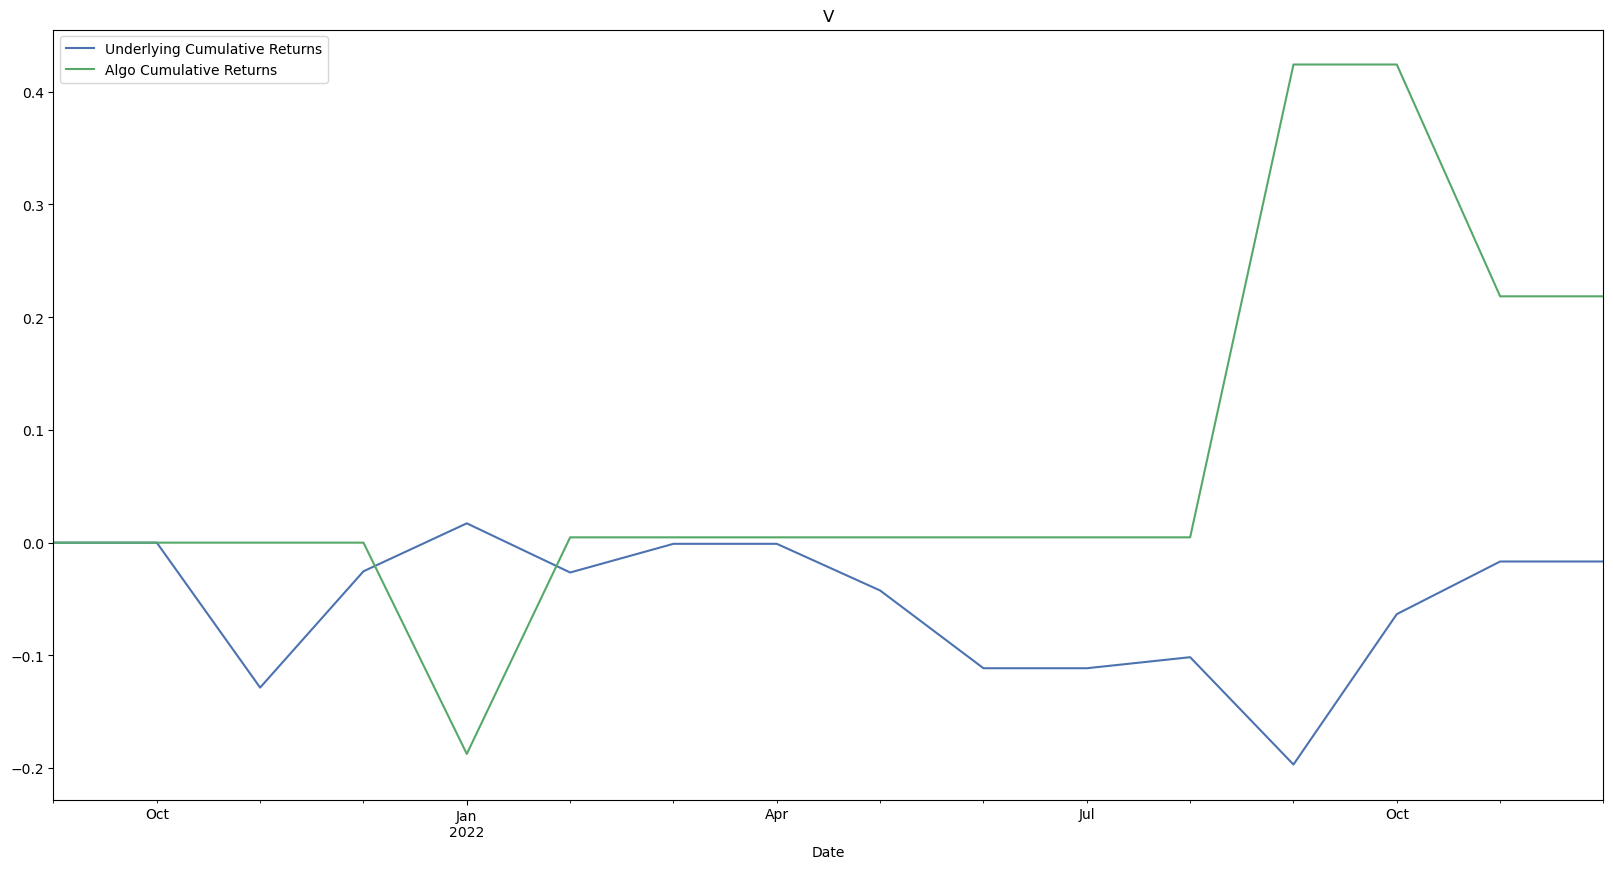

In [17]:
for i in stock_list:
    # Define X and y variables:
    X = all_data.drop(stock_list, axis=1)
    X = X.drop('ret_Fund' ,axis=1)
    y = all_data.loc[:, 'ret_'+i]

    # Split into Training/Testing Data:
    split = int(0.8 * len(X))
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]
    close_test=all_data[i][split:]
    
    xgb_reg = XGBRegressor(booster = 'gbtree', 
                            gamma = 0.05,
                            colsample_bytree = 0.8,
                            colsample_bynode = 0.5,
                            n_estimators = 200, 
                            subsample = 0.8, 
                            min_child_weight = 1, 
                            learning_rate = 0.1) 
    xgb_reg.fit(X_train, y_train)
    predictions = xgb_reg.predict(X_test)

    # Convert y_test to a dataframe:
    y_test = y_test.to_frame()

    signals_df = y_test.copy()

    # Add "predictions" to dataframe:
    y_test['Predictions'] = predictions
    y_test["Close"]=close_test

    # Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
    y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['ret_'+i], 1.0,0.0)

    # Drop nulls:
    y_test=y_test.dropna()

    # Generate and view signals dataframe using generate signals function
    signals_df=generate_signals(y_test)

    # Generate Metrics for Algorithm:
    #algo_evaluation(signals_df)

    # Generate Metrics for Function vs. Buy-and-Hold Strategy:
    #algo_vs_underlying(signals_df)

    # Generate Evaluation table:
    trade_evaluation_df=trade_evaluation(signals_df)
    trade_evaluation_df
    
    print(i)
    print('mean_squared_error =\t\t', mean_squared_error(y_test['ret_'+i], predictions))
    print('mean_absolute_error =\t\t', mean_absolute_error(y_test['ret_'+i], predictions))

    # Generate Cumulative Return plot using above defined function:
    underlying_returns(signals_df).plot(figsize=(20,10))
    plt.title(i)

In [14]:
from pypfopt import EfficientFrontier, expected_returns, risk_models, plotting

In [18]:
price = all_data[stock_list]
price.head()

,AAPL,APTV,BAC,BALL,BEP,BKNG,BMRN,COST,CVS,DE,ETN,GOOGL,HD,HIG,MS,MSFT,PLD,TT,UNH,V
Date,,,,,,,,,,,,,,,,,,,,
2015-10-31,25.098488,60.501385,13.413202,29.074190,9.919103,1236.859985,105.320000,126.199654,79.451347,64.834648,42.034256,31.918501,97.091370,38.758942,25.931971,39.316948,31.566284,34.328056,103.584885,66.182121
2015-11-30,27.034092,70.132378,15.005915,32.510468,9.209794,1248.849976,95.370003,141.272690,77.746063,69.714783,48.121662,38.142502,112.551735,38.819504,28.369062,48.605503,34.690445,39.669628,100.638321,75.200180
2015-12-31,24.054174,68.416580,14.530150,34.060600,9.606071,1274.949951,104.760002,141.342743,80.786819,67.341698,43.057976,38.900501,111.673508,36.965286,26.309614,49.616070,35.163368,37.581120,105.493988,73.810616
2016-01-31,24.054174,68.416580,14.530150,34.060600,9.606071,1274.949951,104.760002,141.342743,80.786819,67.341698,43.057976,38.900501,111.673508,36.965286,26.309614,49.616070,35.163368,37.581120,105.493988,73.810616
2016-02-29,22.215639,53.478298,10.809117,31.076992,9.770716,1265.209961,81.870003,131.660263,80.651634,70.793976,46.921932,35.861000,104.808434,35.825546,20.549963,45.828960,31.509388,37.764641,106.803268,69.035339


In [20]:
mu = expected_returns.capm_return(price)
S = risk_models.CovarianceShrinkage(price).ledoit_wolf()

ef = EfficientFrontier(mu, S)  # weight_bounds automatically set to (0, 1)

ef.max_sharpe()

weights = ef.clean_weights()

In [21]:
weights

OrderedDict([('AAPL', 0.05205),
             ('APTV', 0.05799),
             ('BAC', 0.05217),
             ('BALL', 0.04764),
             ('BEP', 0.04571),
             ('BKNG', 0.04949),
             ('BMRN', 0.04652),
             ('COST', 0.04807),
             ('CVS', 0.04998),
             ('DE', 0.05015),
             ('ETN', 0.05003),
             ('GOOGL', 0.0547),
             ('HD', 0.04648),
             ('HIG', 0.04697),
             ('MS', 0.05424),
             ('MSFT', 0.04741),
             ('PLD', 0.05602),
             ('TT', 0.05381),
             ('UNH', 0.04566),
             ('V', 0.04489)])

In [22]:
ef.portfolio_performance(verbose=True)

Expected annual return: 3973.9%
Annual volatility: 81.5%
Sharpe Ratio: 48.76


(39.73891031715222, 0.814590079417275, 48.759383794074104)